# Финальный проект: вариант 2
## Задание 3. Python and Airflow
##  Anastasiia Sibiriakova (a_sibiriakova)
###  Поток 15.08

***

##  Airflow
Для автоматизации процесса создала Dag в Airflow, для загрузки обновлений и отправки обновленных графиков через бот-телеграм


#### gitlab file
https://git.lab.karpov.courses/lab/airflow/-/blob/master/dags/a-sibiriakova/Variant_2_Task_3_Python_and_Airflow.py
  
#### airflow dag
https://airflow-da.lab.karpov.courses/tree?dag_id=final_project_variant_2_a_sibiriakova_15_08

***

## Python

&darr; импортируем необходимые библиотеки &darr;  

In [1]:
import requests
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

#### Задание 1
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

***

In [10]:
def get_update_data(groups_df, active_studs_df, checks_df):
    """функция, которая будет автоматически подгружает информацию 
    из дополнительного файла groups_add.csv (заголовки могут отличаться) 
    и на основании дополнительных параметров пересчитывает метрики
    """
    
    # на вход функции подаем датафреймы с имеющимися данными
    
    # загружаем дополнительные данные из файла
    groups_add_df = pd.read_csv(get_csv_from_yandex('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ')) 
    
    # объединяем основной файл с пользователями с дополнительным
    groups_all_df = pd.concat([groups_df, groups_add_df], ignore_index=False, verify_integrity=False, sort=False)
    
    # объединяем датафрейм с группами пользователей с датафреймами с активным пользователям и платящим пользователям
    # датафрейм checks_df объединяем с датафреймом active_studs_df, чтобы были платежи только активных пользователей
    data_all = groups_all_df \
        .merge(active_studs_df, how='left', left_on='id', right_on='student_id') \
        .merge(checks_df, how='left', left_on='student_id', right_on='student_id') \
        .rename(columns={'student_id_x': 'active_stud', 'student_id_y': 'paying_stud'})
    
    # группируем пользователей по группам и считаем число всех, активных и платящих, и сумму дохода в каждой группе
    # последней строчкой удаляем мультииндекс
    metrics_df = data_all \
        .groupby('grp', as_index=False) \
        .agg({'id': [('all_stud', 'count')], 
              'student_id': [('active_stud', 'count')], 
              'rev': [('paying_stud', 'count'), ('revenue', 'sum')]}) \
        .droplevel(0, axis=1)
    
    # переименовываем первый столбец, так как при удалении индекса потерялось его название
    metrics_df = metrics_df.rename(columns={metrics_df.columns[0]: 'grp'})
    
    A_all_stud = metrics_df[(metrics_df.grp == 'A')]['all_stud']
    B_all_stud = metrics_df[(metrics_df.grp == 'B')]['all_stud']
    
    A_active_stud = metrics_df[(metrics_df.grp == 'A')]['active_stud']
    B_active_stud = metrics_df[(metrics_df.grp == 'B')]['active_stud']
    
    A_paying_stud = metrics_df[(metrics_df.grp == 'A')]['paying_stud']
    B_paying_stud = metrics_df[(metrics_df.grp == 'B')]['paying_stud']
    
    A_revenue = metrics_df[(metrics_df.grp == 'A')]['revenue']
    B_revenue = metrics_df[(metrics_df.grp == 'B')]['revenue']
    
    # считаем соотношение активных пользователей ко всем пользователям в группе
    CR_A = round(A_active_stud / A_all_stud * 100, 2)
    CR_B = round(B_active_stud / B_all_stud * 100, 2)
    metrics_df['CR_AU'] = pd.Series([CR_A.values[0], CR_B.values[0]], index=[0, 1])
    
    # считаем соотношение платящих пользователей ко всем пользователям в группе
    CR_A = round(A_paying_stud / A_all_stud * 100, 2)
    CR_B = round(B_paying_stud / B_all_stud * 100, 2)
    metrics_df['CR_PU'] = pd.Series([CR_A.values[0], CR_B.values[0]], index=[0, 1])
    
    # считаем соотношение платящих пользователей к активным
    CR_A = round(A_paying_stud / A_active_stud * 100, 2)
    CR_B = round(B_paying_stud / B_active_stud * 100, 2)
    metrics_df['CR_AU_to_PU'] = pd.Series([CR_A.values[0], CR_B.values[0]], index=[0, 1])

    # считаем отношение дохода к числу всех пользователей в группе
    ARPU_A = round(A_revenue / A_all_stud, 2)
    ARPU_B = round(B_revenue / B_all_stud, 2)
    metrics_df['ARPU'] = pd.Series([ARPU_A.values[0], ARPU_B.values[0]], index=[0, 1])
    
    # считаем отношение дохода к числу активных пользователей
    ARPAU_A = round(A_revenue / A_active_stud, 2)
    ARPAU_B = round(B_revenue / B_active_stud, 2)
    metrics_df['ARPAU'] = pd.Series([ARPAU_A.values[0], ARPAU_B.values[0]], index=[0, 1])
    
    # считаем отношение дохода к числу платящих пользователей
    ARPPU_A = round(A_revenue / A_paying_stud, 2)
    ARPPU_B = round(B_revenue / B_paying_stud, 2)
    metrics_df['ARPPU'] = pd.Series([ARPPU_A.values[0], ARPPU_B.values[0]], index=[0, 1])

    # возвращаем датафрейм с рассчитанными метриками
    return (metrics_df)  

***

#### Задание 2
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Обновленные графики сохраняются локально в файлы  
И потом эти графики высылаются телеграм ботом в чат

***

In [3]:
def get_grafics_of_metrics(metrics_df):
    """ функция, которая строит графики по получаемым метрикам
    Обновленные графики сохраняются локально в файлы
    И эти графики высылаются телеграм ботом в чат   
    """
    CR_data = metrics_df[['CR_AU', 'CR_PU', 'CR_AU_to_PU', 'grp']].melt(id_vars='grp', 
                                                                        value_name='value', 
                                                                        var_name='metrics')
    
    ARP_data = metrics_df[['ARPU', 'ARPAU', 'ARPPU', 'grp']].melt(id_vars='grp', 
                                                                  value_name='value', 
                                                                  var_name='metrics')
    
    sns.set(rc={'figure.figsize': (12, 6)}, style="white")

    # строим график
    splot = sns.barplot(data=CR_data, x='value', y='metrics', hue='grp')
    # подписываем бары на графике
    for g in splot.patches:    
        splot.annotate(format(g.get_width(), '.2f'),
                       (g.get_width(), g.get_y() + g.get_height() / 2.),                   
                       ha='center', va='center',                   
                       xytext=(18, 0),                   
                       textcoords='offset points',
                       color='grey',
                       fontweight='bold',
                       fontsize=12)
    # убираем границы
    right_side = splot.spines["right"]
    right_side.set_visible(False)
    top_side = splot.spines["top"]
    top_side.set_visible(False)
    # подписываем сам график и оси
    plt.title('\nКонверсия в оплату\n', fontsize=22)
    plt.xlabel("Конверсия, %", size=14)
    plt.ylabel("Метрика", size=14)

    plt.savefig('CR.png')

    plt.show()
    plt.close()

    # строим график
    splot = sns.barplot(data=ARP_data, x='value', y='metrics', hue='grp')
    # подписываем бары на графике
    for g in splot.patches:    
        splot.annotate(format(g.get_width(), '.0f'),
                       (g.get_width(), g.get_y() + g.get_height() / 2.),                   
                       ha='center', va='center',                   
                       xytext=(16, 0),                   
                       textcoords='offset points',
                       color='grey',
                       fontweight='bold',
                       fontsize=12)
    # убираем границы
    right_side = splot.spines["right"]
    right_side.set_visible(False)
    top_side = splot.spines["top"]
    top_side.set_visible(False)
    # подписываем сам график и оси
    plt.title('\nСредний доход на 1 пользователя\n', fontsize=22)
    plt.xlabel("Средний доход", size=14)
    plt.ylabel("Метрика\n", size=14)

    plt.savefig('ARPU_ARPAU_ARPPU.png')

    plt.show()
    plt.close()
    
    # отправка в телеграм бот
    CHAT_ID = 344844265
    BOT_TOKEN = ''

    message = 'Данные успешно обновлены. Лови обновленные графики'
    if BOT_TOKEN != '':
        params = {'chat_id': CHAT_ID, 'text': message}

        base_url = f'https://api.telegram.org/bot{BOT_TOKEN}/'
        url = base_url + 'sendMessage?' + urlencode(params)
        requests.get(url)
        
        CR = {'photo': open('CR.png', 'rb')}
        ARPU = {'photo': open('ARPU_ARPAU_ARPPU.png', 'rb')}
        
        url = f'{base_url}sendPhoto?chat_id={CHAT_ID}'
        requests.post(url, files=CR)
        requests.post(url, files=ARPU)

***

данные находятся по ссылке на Яндекс диске поэтому нужна предобработка коротких ссылок   
&darr; эта функция &darr;  позволяет преобразовать короткую ссылку в понятный для пандас url для доступа к файлу

In [4]:
# из интернета
from urllib.parse import urlencode 
 
    
def get_csv_from_yandex(link):    
    # используем api 
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    
    # получаем url 
    final_url = base_url + urlencode(dict(public_key=link)) 
    response = requests.get(final_url) 
    download_url = response.json()['href'] 
    
    return download_url

&darr; сохраняем короткие пути до файлов в переменные &darr; 

In [5]:
groups_link = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
active_studs_link = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_link = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

&darr; загружаем данные в df &darr;

In [6]:
groups_df = pd.read_csv(get_csv_from_yandex(groups_link), sep=';') 
active_studs_df = pd.read_csv(get_csv_from_yandex(active_studs_link))
checks_df = pd.read_csv(get_csv_from_yandex(checks_link), sep=';')

***

#### Запускам функции
Вызываем функции для обновления данных и отрисовки графиков  
Обновленные графики будут высланы в телеграм-бот

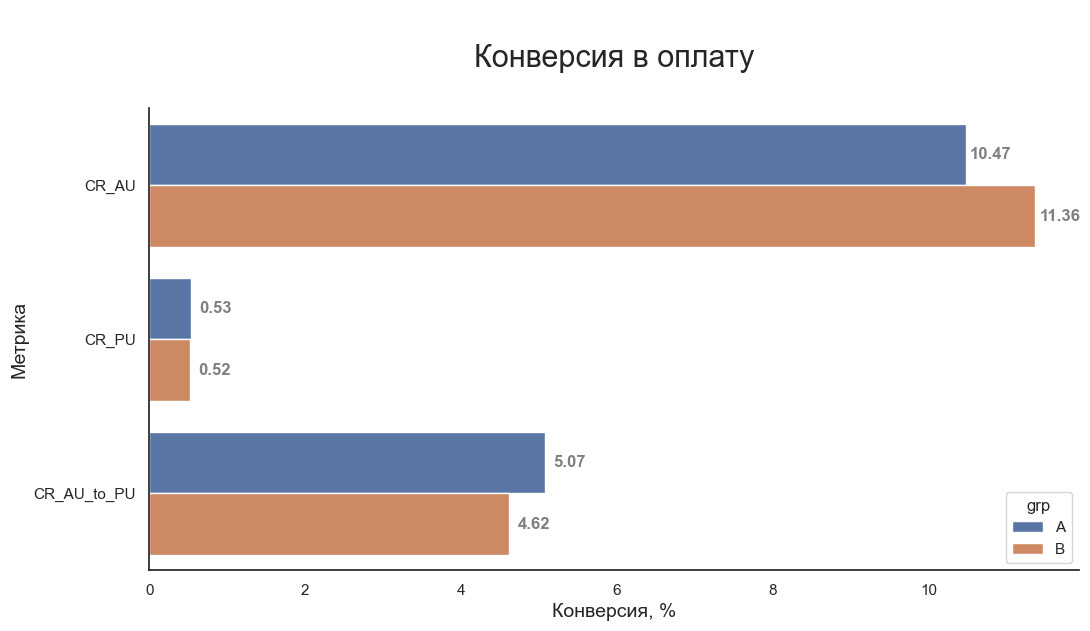

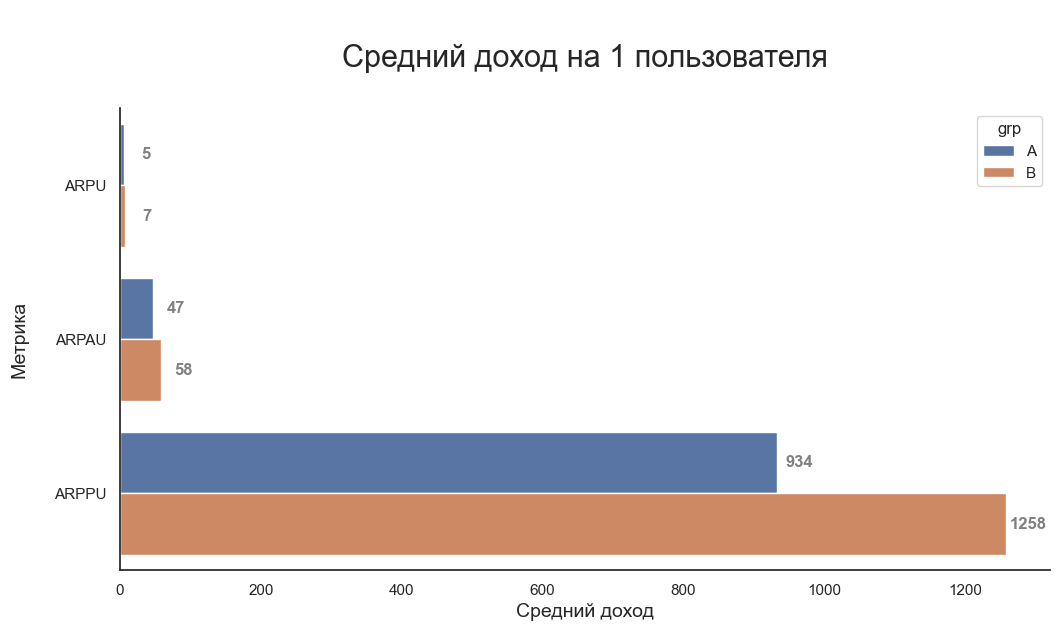

In [11]:
get_grafics_of_metrics(get_update_data(groups_df, active_studs_df, checks_df))